# Tide Receipt Matching Solution

## 0.) Some Task's Before Modelling

### 0.1) Loading of Data
* Loading of the Data and having the glimpse of Data

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv("data_interview_test.csv" , sep = ":")

In [5]:
data.head()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
# lets see if there are any NULL values.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12034 entries, 0 to 12033
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   receipt_id               12034 non-null  object 
 1   company_id               12034 non-null  int64  
 2   matched_transaction_id   12034 non-null  object 
 3   feature_transaction_id   12034 non-null  object 
 4   DateMappingMatch         12034 non-null  float64
 5   AmountMappingMatch       12034 non-null  float64
 6   DescriptionMatch         12034 non-null  float64
 7   DifferentPredictedTime   12034 non-null  float64
 8   TimeMappingMatch         12034 non-null  float64
 9   PredictedNameMatch       12034 non-null  float64
 10  ShortNameMatch           12034 non-null  float64
 11  DifferentPredictedDate   12034 non-null  float64
 12  PredictedAmountMatch     12034 non-null  float64
 13  PredictedTimeCloseMatch  12034 non-null  float64
dtypes: float64(10), int64(

### 0.2) Creating The Target Column
* We will create a target variable which tells wheather feature_transaction_id and matched_transaction_id is same or not and that will be our y label(Target) too.

In [7]:
# Creating a Column Target which tells wheather there is a match or not.

data['Target'] = 0 # filling all the Value with Zero

matched_bool_array = data['matched_transaction_id'] == data['feature_transaction_id']
data.loc[ matched_bool_array , 'Target' ] = 1 # assigning 1 value to all the rows which matched

### 0.3) Train, CV, Test Split
* Splitting our Data into Training , Cross Validation an Testing Purposes.

In [178]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop( ['Target' ,'receipt_id' , 'company_id' , 'matched_transaction_id' , 'feature_transaction_id' ] , axis = 1 ) , data['Target'], stratify = data['Target'], test_size=0.20 , random_state = 8 )
feature_names = X_train.columns
# making a Cv dataset

X_train, X_cv, y_train, y_cv = train_test_split( X_train , y_train, stratify = y_train, test_size=0.15 )

### 0.4) PCA Visualization
* As the Data has more than 2-Dimensions , we will apply PCA to reduce dimensions to 2 so that we can visualize the data.

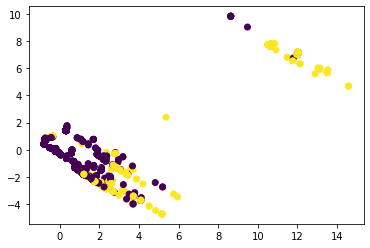

In [179]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)

X_train_pca = StandardScaler().fit_transform(X_train)
components = pca.fit_transform(X_train_pca)
plot = plt.scatter(components[:,0], components[:,1], c=list(y_train))

In [180]:
print( f"+Tive Points - {len(y_train[y_train == 1])}")
print( f"-Tive Points - {len(y_train[y_train == 0])}")

+Tive Points - 583
-Tive Points - 7599


### Summary:
* Data Doesn't have any missing Values.
* Data Seems to be imbalanced needs balancing.
* After PCA visualization seems like there is some kind of seperation maybe we can leverage it.

### 0.5) Oversampling of Data(SMOTE)
* As the Data is imbalanced we will Balance the Data with SMOTE (Creates Artificial Synthetic Data points)

In [181]:
# oversampling the data
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 0)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

print(f"After Oversampling -ve points - {len(y_train[y_train == 0])}")
print(f"After Oversampling +ve points - {len(y_train[y_train == 1])}")

After Oversampling -ve points - 7599
After Oversampling +ve points - 7599


## 1.) Modelling

### 1.1) SGD(Logistic Regression)
* Applying Logistic Regression for Different Parameters.
* plotting the Loss for Different Parameters.
* Plotting Precision Recall Curve.
* Testing the Model on test data.

In [182]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()  
X_train_Scaled = scaler.fit_transform(X_train)

training_losses , cv_losses , hyper_parameters = [] , [] , []

for exp_par in range(-6 , 5  , 1):
    model = SGDClassifier(loss = 'log_loss' , random_state = 2, alpha = 10**exp_par).fit(X_train_Scaled , y_train)
    X_cv_scaled = scaler.transform(X_cv)
    
    training_loss = log_loss(y_train, model.predict_proba(X_train_Scaled))
    cv_loss = log_loss(y_cv, model.predict_proba(X_cv_scaled))
    
    training_losses.append( training_loss )
    cv_losses.append(cv_loss)
    hyper_parameters.append(exp_par)
    
    
# plotting the loss now after training


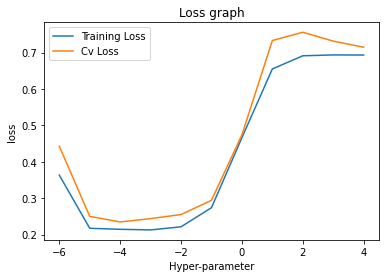

In [183]:
import matplotlib.pyplot as plt

plt.plot(hyper_parameters , training_losses)
plt.plot(hyper_parameters , cv_losses)
plt.xlabel('Hyper-parameter')
plt.ylabel('loss')
plt.title('Loss graph')
plt.legend(['Training Loss' , 'Cv Loss'])
plt.show()

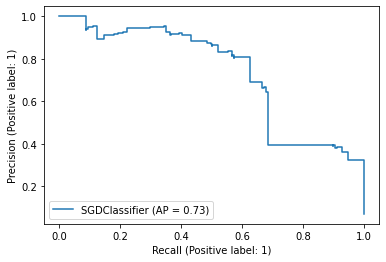

In [188]:
from sklearn.metrics import PrecisionRecallDisplay
model = SGDClassifier(loss = 'log_loss' , random_state = 10 , alpha = 10**-4).fit(X_train_Scaled , y_train)
PrecisionRecallDisplay.from_estimator(model, scaler.transform(X_test), y_test)

In [191]:
model = SGDClassifier(loss = 'log_loss' , random_state = 10 , alpha = 10**-4).fit(X_train_Scaled , y_train)
X_test_scaled = scaler.transform(X_test)
test_loss = log_loss(y_test, model.predict_proba(X_test_scaled))
model_name = "Logistic_Regression"
print(f"Test Loss Found To be {test_loss} for {model_name}")

Test Loss Found To be 0.2239135482300596 for Logistic_Regression


### 1.2) Decision Tree
* Applying Decision Tree for Different Parameters.
* plotting the Loss for Different Parameters.
* Plotting Precision Recall Curve.
* Testing the Model on test data.

In [192]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

scaler = StandardScaler()  
X_train_Scaled = scaler.fit_transform(X_train)

training_losses , cv_losses , hyper_parameters = [] , [] , []

for exp_par in range( 2 ,12  , 1):
    model = tree.DecisionTreeClassifier(max_depth = exp_par ).fit(X_train_Scaled , y_train)
    X_cv_scaled = scaler.transform(X_cv)
    
    training_loss = log_loss(y_train, model.predict_proba(X_train_Scaled))
    cv_loss = log_loss(y_cv, model.predict_proba(X_cv_scaled))
    
    training_losses.append( training_loss )
    cv_losses.append(cv_loss)
    hyper_parameters.append(exp_par)
    
    
# plotting the loss now after training


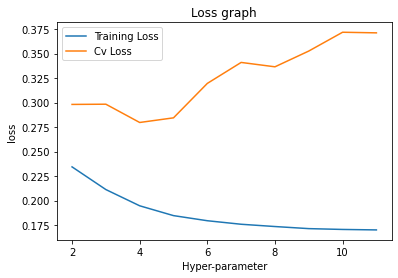

In [193]:
import matplotlib.pyplot as plt

plt.plot(hyper_parameters , training_losses)
plt.plot(hyper_parameters , cv_losses)
plt.xlabel('Hyper-parameter')
plt.ylabel('loss')
plt.title('Loss graph')
plt.legend(['Training Loss' , 'Cv Loss'])
plt.show()

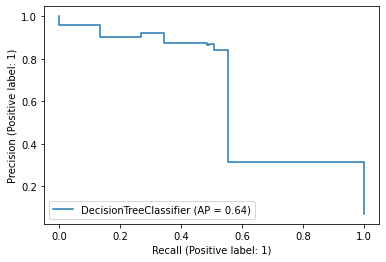

In [194]:
from sklearn.metrics import PrecisionRecallDisplay
model = tree.DecisionTreeClassifier(max_depth = 4 ).fit(X_train_Scaled , y_train)
PrecisionRecallDisplay.from_estimator(model, scaler.transform(X_test), y_test)

In [195]:
model = tree.DecisionTreeClassifier(max_depth = 4 ).fit(X_train_Scaled , y_train)
X_test_scaled = scaler.transform(X_test)
test_loss = log_loss(y_test, model.predict_proba(X_test_scaled))
model_name = "Decision Tree"
print(f"Test Loss Found To be {test_loss} for {model_name}")

Test Loss Found To be 0.2420922080241465 for Decision Tree


### 1.3) Random Forest(Ensemble)
* Applying Random Forest for Different Parameters.
* plotting the Loss for Different Parameters.
* Plotting Precision Recall Curve.
* Testing the Model on test data.

In [196]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()  
X_train_Scaled = scaler.fit_transform(X_train)

training_losses , cv_losses , hyper_parameters = [] , [] , []

for exp_par in range( 0 ,4  , 1):
    model = RandomForestClassifier(n_estimators = 10**exp_par ,max_depth=12, random_state=4).fit(X_train_Scaled , y_train)
    X_cv_scaled = scaler.transform(X_cv)
    
    training_loss = log_loss(y_train, model.predict_proba(X_train_Scaled))
    cv_loss = log_loss(y_cv, model.predict_proba(X_cv_scaled))
    
    training_losses.append( training_loss )
    cv_losses.append(cv_loss)
    hyper_parameters.append(exp_par)

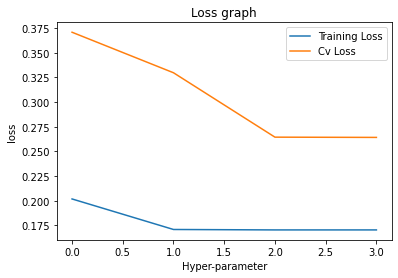

In [197]:
import matplotlib.pyplot as plt

plt.plot(hyper_parameters , training_losses)
plt.plot(hyper_parameters , cv_losses)
plt.xlabel('Hyper-parameter')
plt.ylabel('loss')
plt.title('Loss graph')
plt.legend(['Training Loss' , 'Cv Loss'])
plt.show()

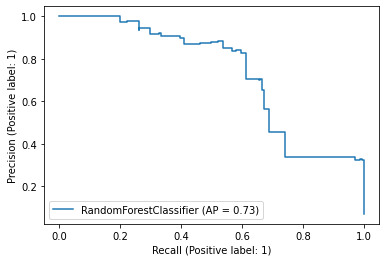

In [198]:
from sklearn.metrics import PrecisionRecallDisplay
model = RandomForestClassifier(n_estimators = 10**2 ,max_depth=12, random_state=2).fit(X_train_Scaled , y_train)
PrecisionRecallDisplay.from_estimator(model, scaler.transform(X_test), y_test)

In [199]:
model = RandomForestClassifier(n_estimators = 10**2 ,max_depth=12, random_state=3).fit(X_train_Scaled , y_train)
X_test_scaled = scaler.transform(X_test)
test_loss = log_loss(y_test, model.predict_proba(X_test_scaled))
model_name = "Random Forest"
print(f"Test Loss Found To be {test_loss} for {model_name}")

Test Loss Found To be 0.21696142398681997 for Random Forest


### Summary
* Decision Seems to be overfitting Clearly after certain depth.
* Logistic Regression seems to work best fit on the data till now.
* Random Forest Seems to work good but observing goodness of fit , Cost , and other Metric's Lets go with Logistic Regression.

### 2.1) Feature Importance
* As we are using the Logisitic Regression so the weights(Coeffients) can also be interpreted as the importance.

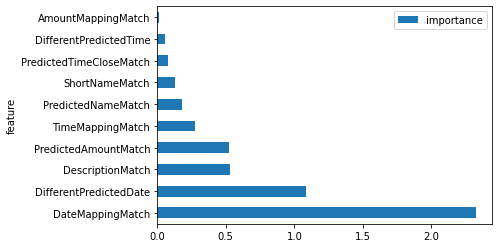

In [204]:
import math
model = SGDClassifier(loss = 'log_loss' , random_state = 10 , alpha = 10**-4).fit(X_train_Scaled , y_train)

feature_names = feature_names
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])

weights = model.coef_[0]
feature_importance["importance"] = abs(weights)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

### Summary
* DateMappingMatch seems to be holding the highest value as a feature.

### 3.1) Creating train.py file
* Combining All the code above to create a final pipeline(Model) for training.

In [205]:
# train.py
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pickle
# loading and creating the Target Variable
data = pd.read_csv("data_interview_test.csv" , sep = ":")
data['Target'] = 0 # filling all the Value with Zero
matched_bool_array = data['matched_transaction_id'] == data['feature_transaction_id']
data.loc[ matched_bool_array , 'Target' ] = 1 # assigning 1 value to all the rows which matched

# train cv , test split
X_train, X_test, y_train, y_test = train_test_split( data.drop( ['Target' ,'receipt_id' , 'company_id' , 'matched_transaction_id' , 'feature_transaction_id' ] , axis = 1 ) , data['Target'], stratify = data['Target'], test_size=0.20 , random_state = 5 )
feature_names = X_train.columns
X_train, X_cv, y_train, y_cv = train_test_split( X_train , y_train, stratify = y_train, test_size=0.15 )

# over sampling the data
sm = SMOTE(random_state = 0)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

# forming a pipeline for transforming the data followed by training the model

pipeline = Pipeline([('scaler', StandardScaler()), ('SGD',SGDClassifier(loss='log_loss',random_state = 2,alpha = 10**-4) ) ])
pipeline.fit(X_train.values , y_train)

with open('log_regress.sav', 'wb') as model:
    pickle.dump(pipeline , model)
    
with open('log_regress.sav' , 'rb') as model:
    pipeline = pickle.load(model)

#pipeline.score(X_test.values , y_test)

### 3.1) Creating predict.py
* predict contains the a predict_rank function which recieves a pipeline(model) , and input_data(receipt data in 2-D format).
* predict_and_rank function outputs the data in order of the matched likelyhood and a extra value at the end of each row containing the probability.

In [206]:
# predict.py
import pickle
def predict_and_rank(model , input_):
    data = input_.copy()
    length = len(data)
    
    # appending probablities of having a match at the end of each row.
    for iter_ in range(length):
        probability =  { 'prob':model.predict_proba( [data[iter_][3:]] )[0][1] }
        data[iter_].append( probability )
    
    # sorting on the Basis of Probability which is appended in each row just previously.
    data.sort(key=lambda a: a[-1]['prob'] ,reverse = True)
    return data

if __name__ == '__main__':
    # please give the input to the above function only in this order
    """" 
    Please give the input in the following order - 
    -------------------------------------------------------------------------------------------------------
    receipt_id ,company_id ,feature_transaction_id
    DateMappingMatch, AmountMappingMatch, DescriptionMatch,DifferentPredictedTime, TimeMappingMatch, 
    PredictedNameMatch,ShortNameMatch, DifferentPredictedDate, PredictedAmountMatch,PredictedTimeCloseMatch 
    -------------------------------------------------------------------------------------------------------
    """
    # just some sample testing here
    sample = [
    ['40' , 'company_1' , 'xyz' , 0.1,0.2,0.1,0.4,0.5,0.1,0.4,0.1 , 0.2 ,0.1] ,
    ['40' , 'company_1' , 'abc' , 0.1,0.2,0.1,0.4,0.5,0.1,0.4,0.1 , 0.2 ,0.2] , 
    ['40' , 'company_1' , 'qwe' , 0.2,0.2,0.1,0.4,0.5,0.1,0.4,0.1 , 0.2 ,0.2]
    ]
    
    with open('log_regress.sav' , 'rb') as model:
        pipeline = pickle.load(model)
    
    print(*predict_and_rank(pipeline , sample) , sep  ='\n')

['40', 'company_1', 'qwe', 0.2, 0.2, 0.1, 0.4, 0.5, 0.1, 0.4, 0.1, 0.2, 0.2, {'prob': 0.9358477252809482}]
['40', 'company_1', 'abc', 0.1, 0.2, 0.1, 0.4, 0.5, 0.1, 0.4, 0.1, 0.2, 0.2, {'prob': 0.873844807593935}]
['40', 'company_1', 'xyz', 0.1, 0.2, 0.1, 0.4, 0.5, 0.1, 0.4, 0.1, 0.2, 0.1, {'prob': 0.8646832872533532}]


In [207]:
#do train test split -- Done
#data visulaization , PCA (optional) -- Done
#check imbalancing and balance. --done
#check different models. --done
#implement precision recall function. --done
#check feature importance. --done
#build pre and post pipeline and prepare sorting mechanism and runtime. -- done 
#documentation. -- done
#structurize and commit.

In [208]:
!pip freeze > requirements.txt

In [209]:
from predict import predict_and_rank

In [214]:
sample = [
    ['40' , 'company_1' , 'xyz' , 0.1,0.2,0.1,0.4,0.5,0.1,0.4,0.1 , 0.2 ,0.1] ,
    ['40' , 'company_1' , 'abc' , 0.1,0.2,0.1,0.4,0.5,0.1,0.4,0.1 , 0.2 ,0.2] , 
    ['40' , 'company_1' , 'qwe' , 0.2,0.2,0.1,0.4,0.5,0.1,0.4,0.1 , 0.2 ,0.2]
    ]
with open('log_regress.sav' , 'rb') as model:
        pipeline = pickle.load(model)
print(*predict_and_rank(pipeline , sample) , sep = '\n')

['40', 'company_1', 'qwe', 0.2, 0.2, 0.1, 0.4, 0.5, 0.1, 0.4, 0.1, 0.2, 0.2, {'prob': 0.9358477252809482}]
['40', 'company_1', 'abc', 0.1, 0.2, 0.1, 0.4, 0.5, 0.1, 0.4, 0.1, 0.2, 0.2, {'prob': 0.873844807593935}]
['40', 'company_1', 'xyz', 0.1, 0.2, 0.1, 0.4, 0.5, 0.1, 0.4, 0.1, 0.2, 0.1, {'prob': 0.8646832872533532}]
